# Data loading

In [2]:
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
jar1 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling2', 'fuel_swelling3']
jar1.drop(columns=columns_drop, inplace=True)

jar2 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling3']
jar2.drop(columns=columns_drop, inplace=True)

jar3 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling2']
jar3.drop(columns=columns_drop, inplace=True)

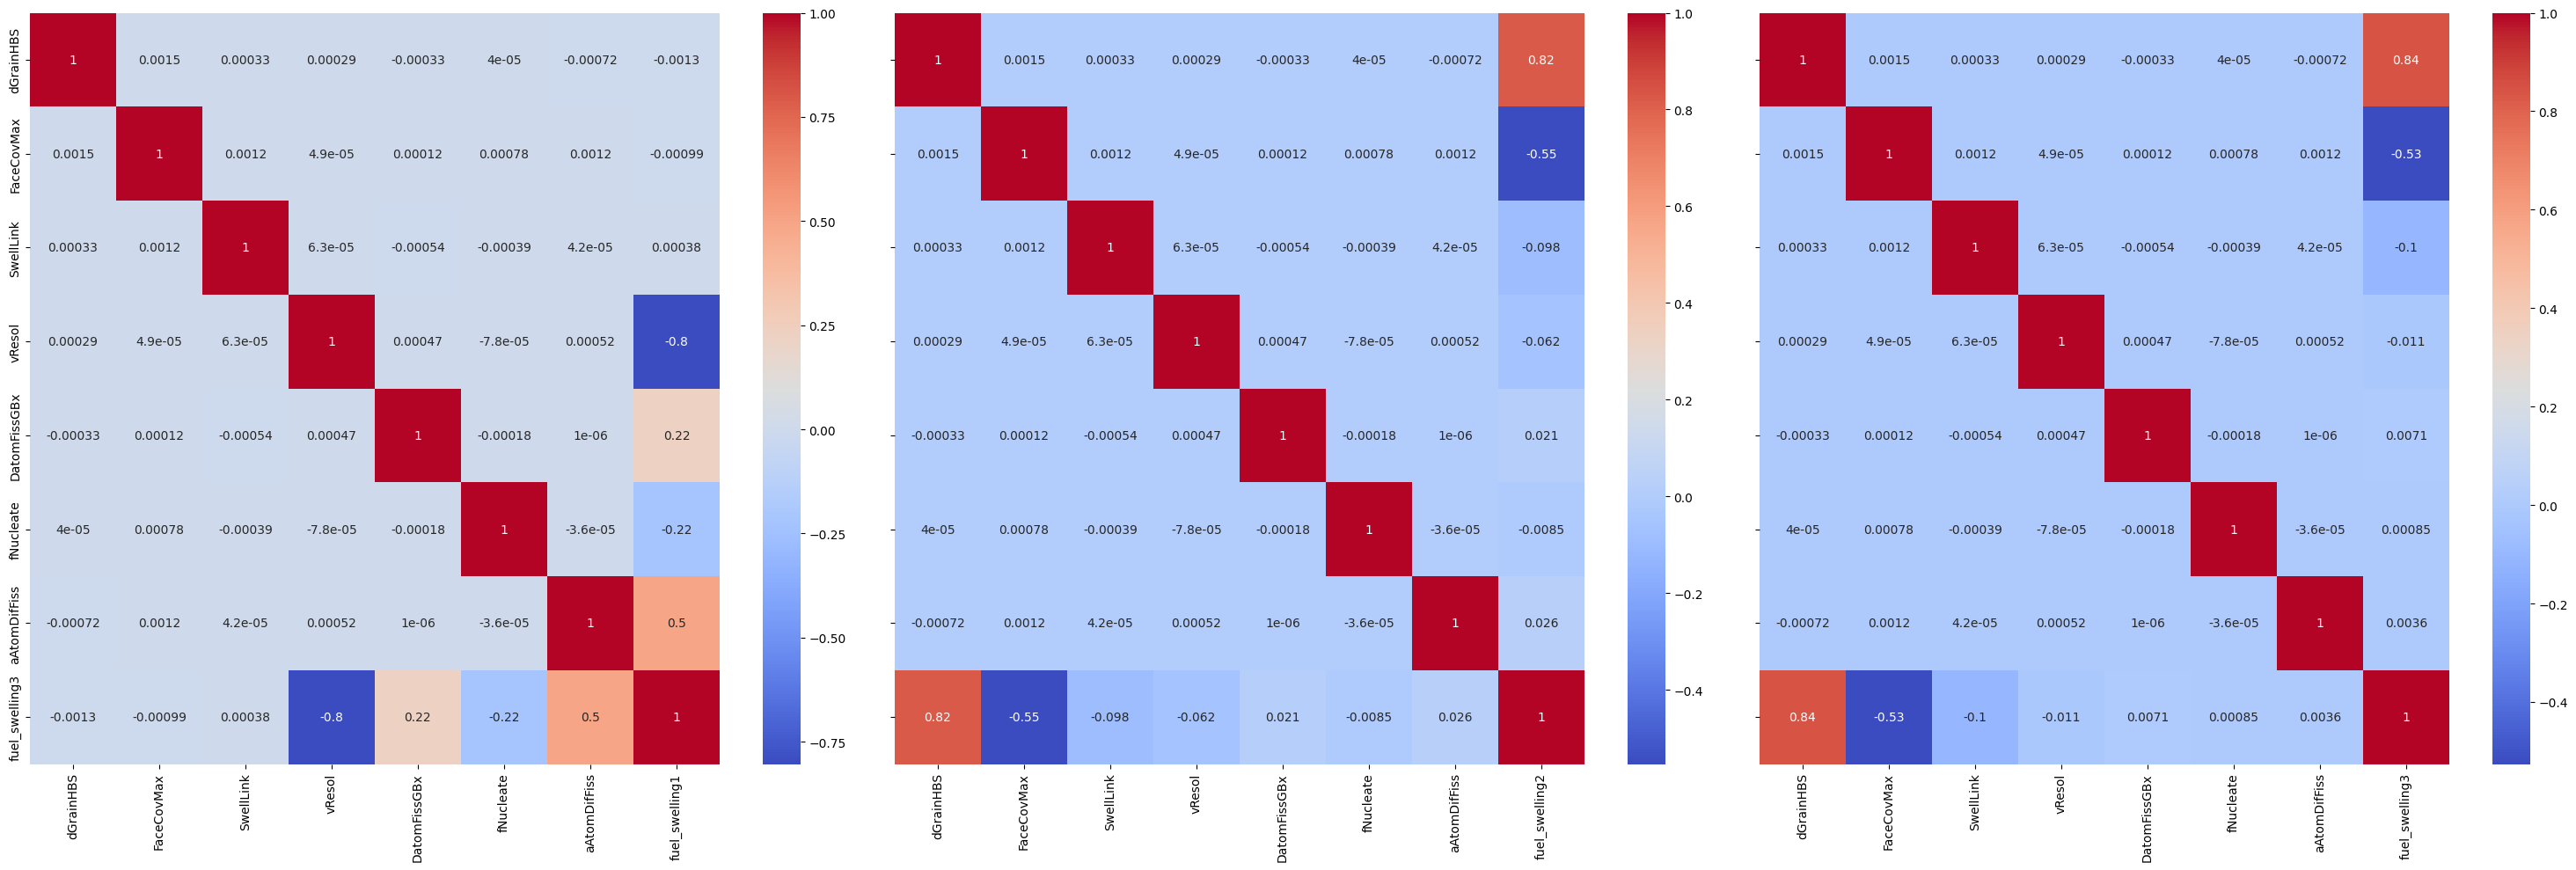

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
jar = [jar1, jar2, jar3]

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(jar[i].corr(), ax=ax, annot=True, cmap='coolwarm')

plt.tight_layout()
plt.show()

# Lasso

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [9]:
feat_ind = list(range(7))
features = jar1.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)

In [10]:
y1 = jar1['fuel_swelling1']
y2 = jar2['fuel_swelling2']
y3 = jar3['fuel_swelling3']

In [11]:
reg1 = linear_model.Lasso(alpha=0.0001)
reg2 = linear_model.Lasso(alpha=0.05)
reg3 = linear_model.Lasso(alpha=0.05)

In [12]:
reg1.fit(X, y1)
reg2.fit(X, y2)
reg3.fit(X, y3)

Lasso(alpha=0.05)

In [13]:
print(reg1.score(X, y1),
      reg2.score(X, y2),
      reg3.score(X, y3))

0.9945986202754518 0.9836855077330949 0.9960206085728976


In [14]:
print(reg1.coef_,
      reg2.coef_,
      reg3.coef_)

[-0.         -0.          0.         -0.04141011  0.01134037 -0.01148808
  0.02568774] [ 0.71033701 -0.462806   -0.04027632 -0.00708918  0.         -0.
  0.        ] [ 2.77711992 -1.72138455 -0.30120118 -0.          0.          0.
  0.        ]


# MCMC

In [15]:
def target_dist(x, mu, sig):
    return np.exp(-0.5 * ((x-mu)/sig)**2)

In [16]:
def candidate_dist(x, sig):
    return np.random.normal(x, sig)

In [17]:
def mod_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, models):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]

        mus = [10.452, 25.808, 46.068]
        # 2 sig = 15% of the mu => sig = 0.075
        sigs = [xx * 0.075 for xx in mus]

        arr = [0, 1, 2]            # [0,1,2] -> [2,4,6] F_d
        fd_ind = random.choice(arr)
        
        mu = mus[fd_ind]
        sig = sigs[fd_ind]
        model = models[fd_ind]

        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 6              # just to start the loop
            while (abs(proposed_p) > 3):
                proposed_p = candidate_dist(current_p, proposal_sigma)
            #proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0]
            theta2 = model.predict([[*proposed_state]])[0]

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2, mu, sig) / target_dist(theta1, mu, sig)

            if np.random.rand() < acceptance_ratio and acceptance_ratio != 1:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [18]:
regs = [reg1, reg2, reg3]
hey = mod_mcmc_sampler(7, 100000, np.zeros(7), 0.2, regs)

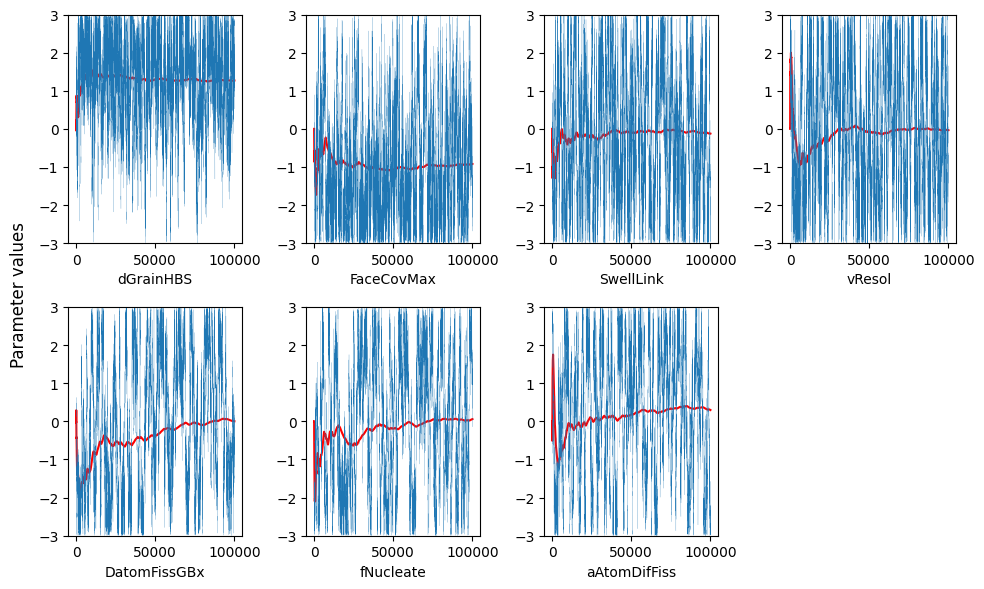

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    cdat = hey[:,i]
    cavg = np.cumsum(cdat) / np.arange(1, len(cdat)+1)
    ax.plot(cavg, c='r')
    ax.plot(cdat, lw=0.1)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

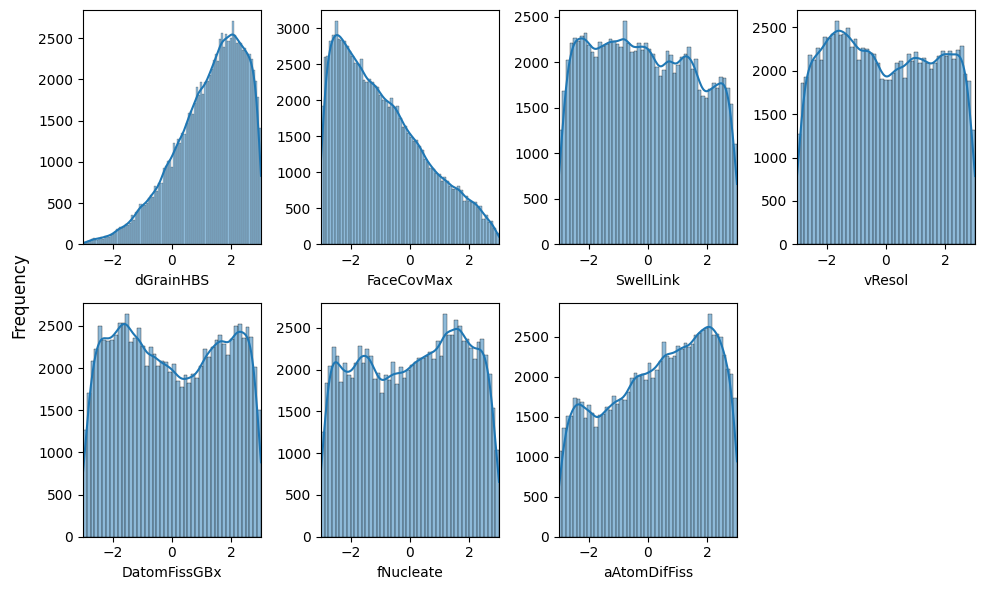

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylabel('')
    ax.set_xlim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

In [21]:
yay = xscaler.inverse_transform(hey)

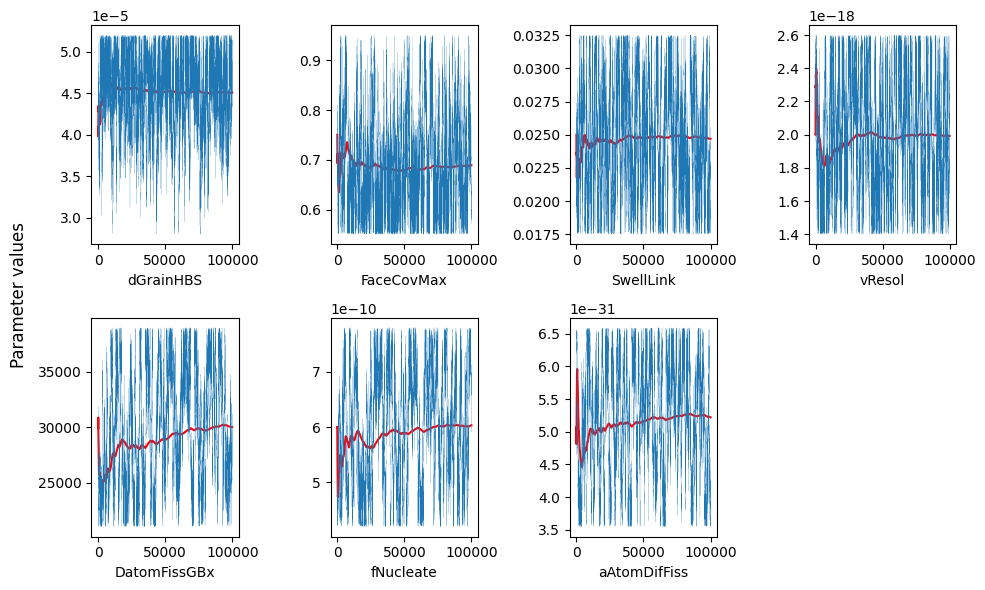

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    cdat = yay[:,i]
    cavg = np.cumsum(cdat) / np.arange(1, len(cdat)+1)
    ax.plot(cavg, c='r')
    ax.plot(cdat, lw=0.1)
    ax.set_xlabel(jar1.columns[i])
    #ax.set_ylim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

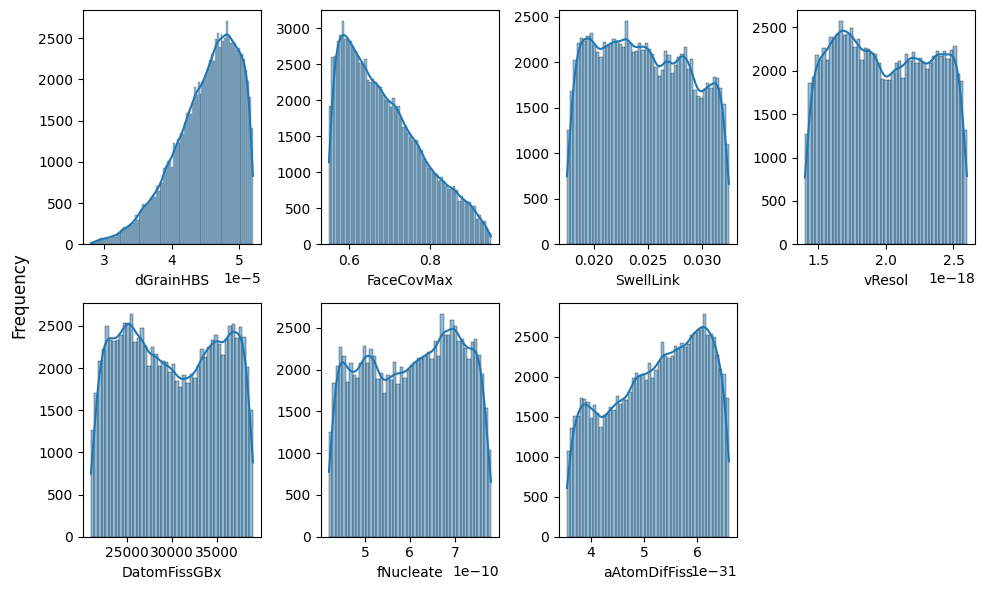

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(yay[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylabel('')

fig.delaxes(axes[1,3])
fig.supylabel('Frequency')
plt.tight_layout()
plt.show()

# Forward UQ

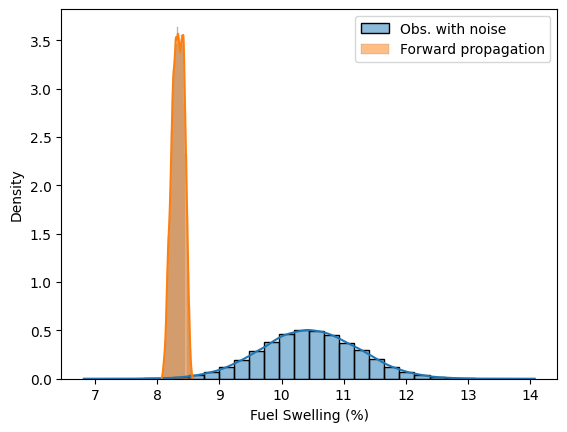

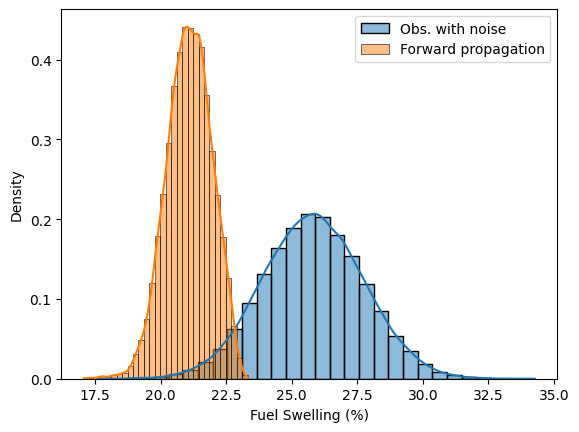

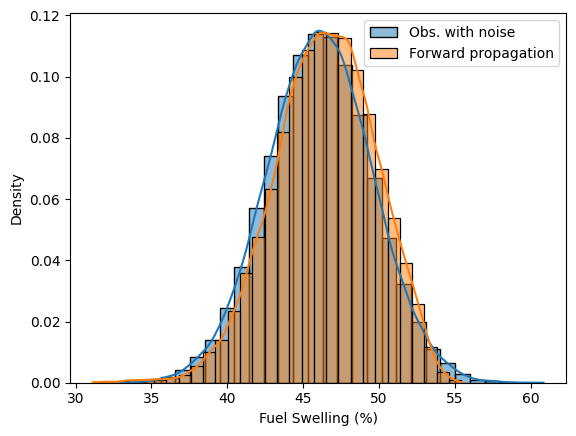

In [24]:
mus = [10.452, 25.808, 46.068]
# 2 sig = 15% of the mu => sig = 0.075
sigs = [xx * 0.075 for xx in mus]

for mod, mu, sig in zip([reg1, reg2, reg3], mus, sigs):
    orig = []
    res = []
    for i in range(100000):
        res.append(mod.predict([hey[-i]])[0])
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fuel Swelling (%)')
    plt.legend()
    plt.show()

# Distribution fitting

In [90]:
col_avg = np.mean(yay, axis=0)

In [91]:
print(col_avg)

[4.54959285e-05 6.90742329e-01 2.51324873e-02 1.97972802e-18
 3.01185517e+04 5.86294455e-10 5.29235592e-31]


In [93]:
from scipy import stats

In [136]:
a = list(range(7))
b = list(range(7))

In [137]:
a[0], b[0] = stats.gumbel_l.fit(yay[:,0])
a[1], b[1] = stats.gumbel_r.fit(yay[:,1])
for i in range(2, 7):
    a[i], b[i] = stats.uniform.fit(yay[:,i])

In [141]:
jag = []
for j in range(10000):
    asd = []
    asd.append(stats.gumbel_l.rvs(a[0], b[0], 1)[0])
    asd.append(stats.gumbel_r.rvs(a[1], b[1], 1)[0])
    for i in range(2, 7):
        asd.append(stats.uniform.rvs([a[i], b[i], 1])[0])
    jag.append(asd)

In [153]:
xxs = StandardScaler()
gg = xxs.fit_transform(jag)

In [155]:
gg[:5]

array([[ 0.71185884, -0.7154027 , -0.70784302, -1.63039696,  0.7331832 ,
        -0.15006683, -1.37942363],
       [-0.98139726,  1.19215608, -0.8554924 , -1.19096976,  0.8965018 ,
         0.6288227 ,  1.69531161],
       [-0.16500544,  0.37856006, -0.78792144, -0.15608131, -1.62266422,
        -0.29198883, -1.3080981 ],
       [ 0.04504077, -1.05959667, -0.09840008,  0.51367417, -0.77989705,
        -1.09080613,  1.03311427],
       [ 1.06803543, -0.73057733,  0.97545713, -0.62759654,  1.08344989,
        -1.45877517,  0.03349727]])

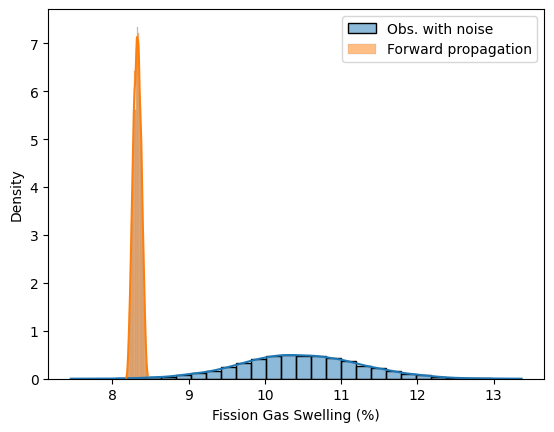

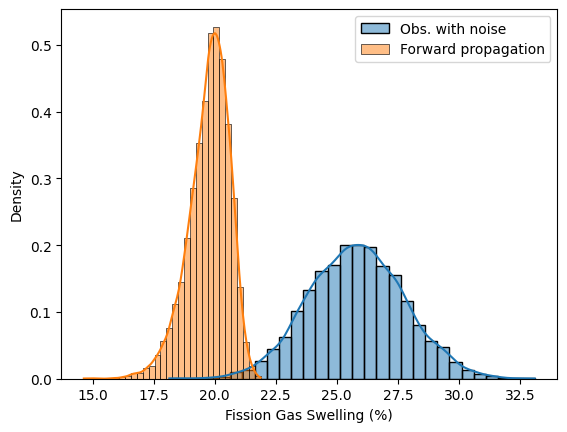

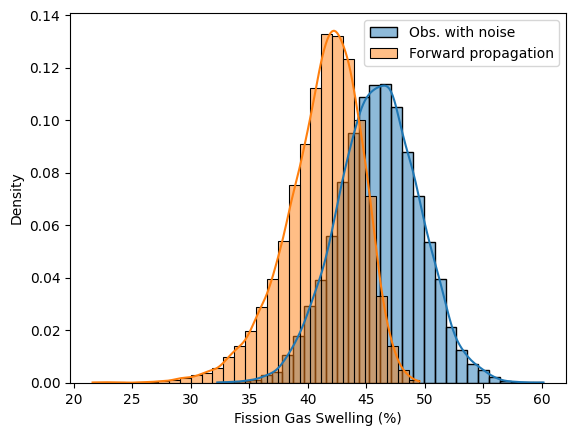

In [157]:
mus = [10.452, 25.808, 46.068]
# 2 sig = 15% of the mu => sig = 0.075
sigs = [xx * 0.075 for xx in mus]

for mod, mu, sig in zip([reg1, reg2, reg3], mus, sigs):
    orig = []
    res = []
    for i in range(10000):
        res.append(mod.predict([gg[-i]])[0])
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fission Gas Swelling (%)')
    plt.legend()
    plt.show()

In [158]:
print(a, b)

[4.754147715417192e-05, 0.6455285271607288, 0.01750236767110254, 1.4003151708564389e-18, 21005.767686967913, 4.1988808759895334e-10, 3.548681151811218e-31] [3.472122815880996e-06, 0.07592214189003996, 0.014996185119225111, 1.1993519916712511e-18, 17988.54871191761, 3.6020105331676914e-10, 3.042813055883755e-31]


<Axes: ylabel='Density'>

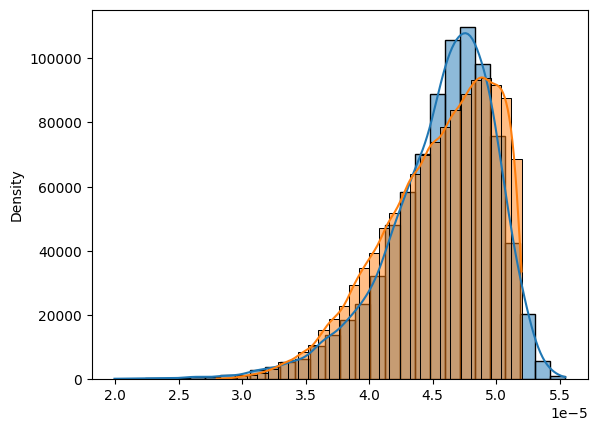

In [130]:
a, b = stats.gumbel_l.fit(yay[:,0])
samp = stats.gumbel_l.rvs(a, b, 10000)

sns.histplot(samp, kde=True, bins=30, ec='k', stat='density', label='Fit')
sns.histplot(yay[:,0], kde=True, bins=30, ec='k', stat='density', label='Data')

<Axes: ylabel='Density'>

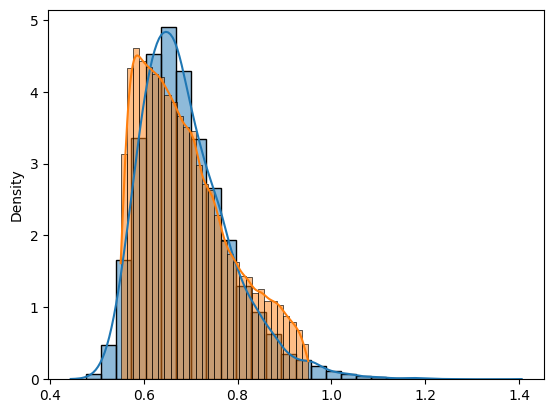

In [131]:
a, b = stats.gumbel_r.fit(yay[:,1])
samp = stats.gumbel_r.rvs(a, b, 10000)

sns.histplot(samp, kde=True, bins=30, ec='k', stat='density', label='Fit')
sns.histplot(yay[:,1], kde=True, bins=30, ec='k', stat='density', label='Data')

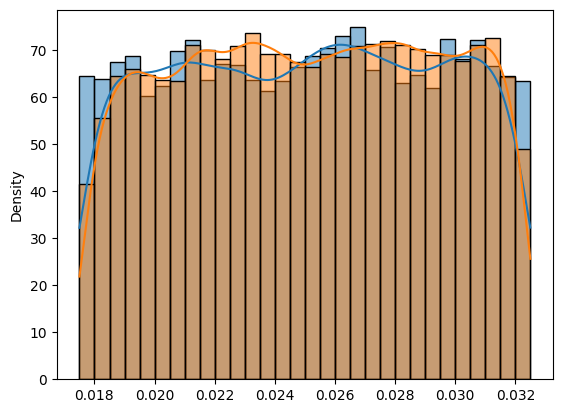

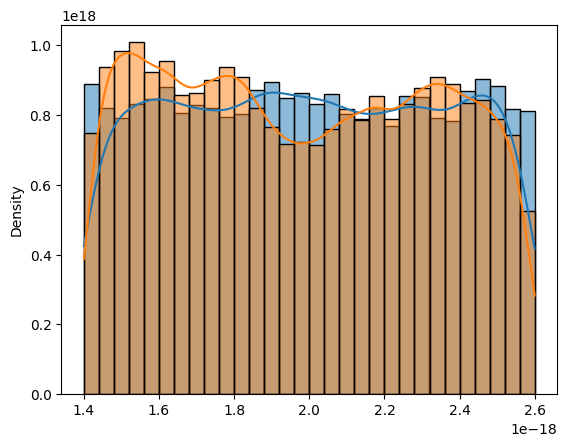

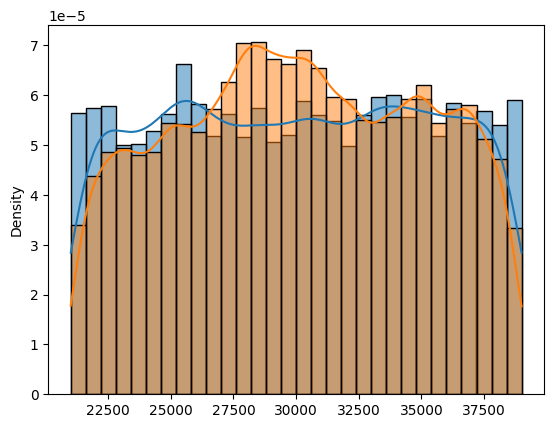

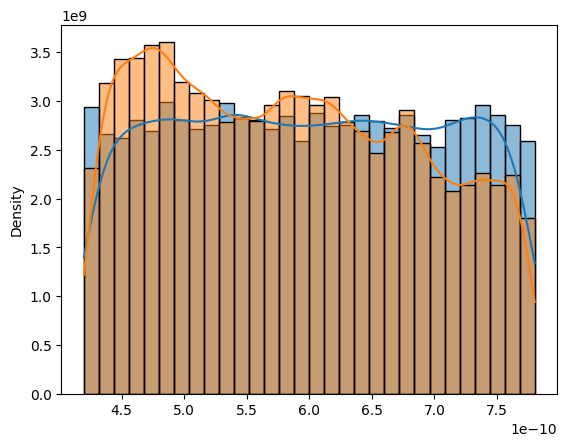

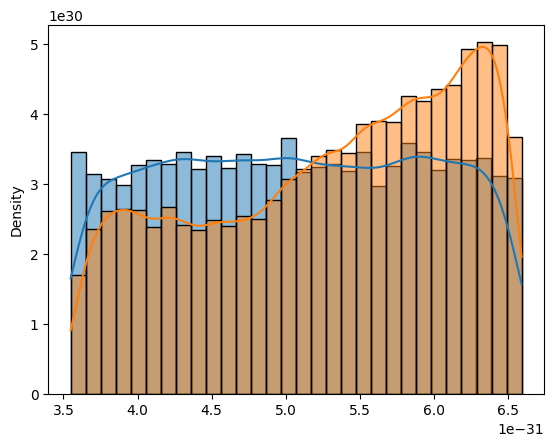

In [135]:
for i in range(2, 7):
    a, b = stats.uniform.fit(yay[:,i])
    samp = stats.uniform.rvs(a, b, 10000)
    
    sns.histplot(samp, kde=True, bins=30, ec='k', stat='density', label='Fit')
    sns.histplot(yay[:,i], kde=True, bins=30, ec='k', stat='density', label='Data')
    plt.show()